## SPE 1-Day Short Course Getting Started with Deep Learning
---

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import imageio

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras

In [105]:
train_image = imageio.imread("./data/seismic/S1.png")
train_annotation = imageio.imread("./data/labels/L1.png")

validation_image = imageio.imread("./data/seismic/S2.png")
validation_annotation = imageio.imread("./data/labels/L2.png")

print("Image Dimensions: ", train_image.shape)

Image Dimensions:  (409, 651)


In [106]:
for class_label, value in zip(range(len(np.unique(train_annotation))), np.unique(train_annotation)):
    train_annotation[np.where(train_annotation==value)] = class_label
    
for class_label, value in zip(range(len(np.unique(validation_annotation))), np.unique(validation_annotation)):
    validation_annotation[np.where(validation_annotation==value)] = class_label

In [107]:
print("Classes in Train: ", np.unique(train_annotation), "Classes in Validation: ", np.unique(validation_annotation))

Classes in Train:  [0 1 2 3 4 5 6 7 8 9] Classes in Validation:  [0 1 2 3 4 5 6 7 8 9]


Text(0.5,1,'Annotations')

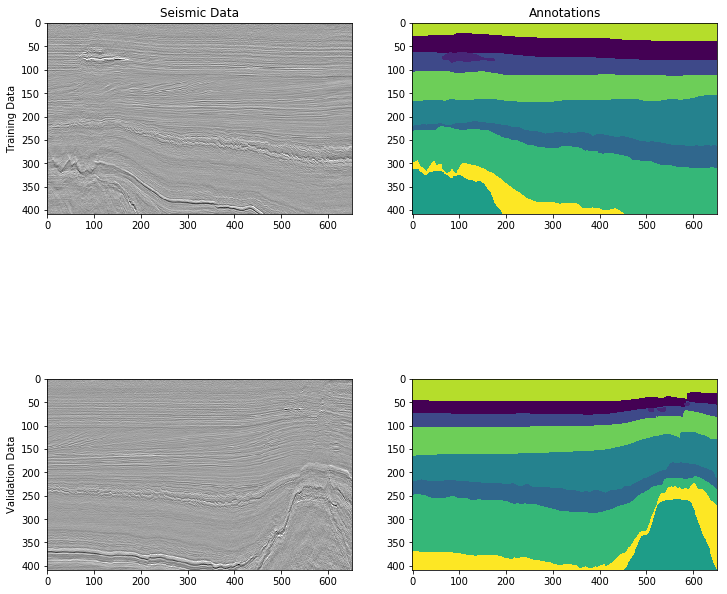

In [108]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(train_image, vmin=train_image.min(), vmax=train_image.max(), cmap="gray")
ax[0, 1].imshow(train_annotation, vmin=0, vmax=9)

ax[1, 0].imshow(validation_image, vmin=train_image.min(), vmax=train_image.max(), cmap="gray")
ax[1, 1].imshow(validation_annotation, vmin=0, vmax=9)

ax[0, 0].set_ylabel("Training Data")
ax[1, 0].set_ylabel("Validation Data")
ax[0, 0].set_title("Seismic Data")
ax[0, 1].set_title("Annotations")

In [14]:
train_mean, train_std = train_image.mean(), train_image.std()

train_image_normed = (train_image-train_mean)/train_std
validation_image_normed = (validation_image-train_mean)/train_std

Text(0.5,1,'Annotations')

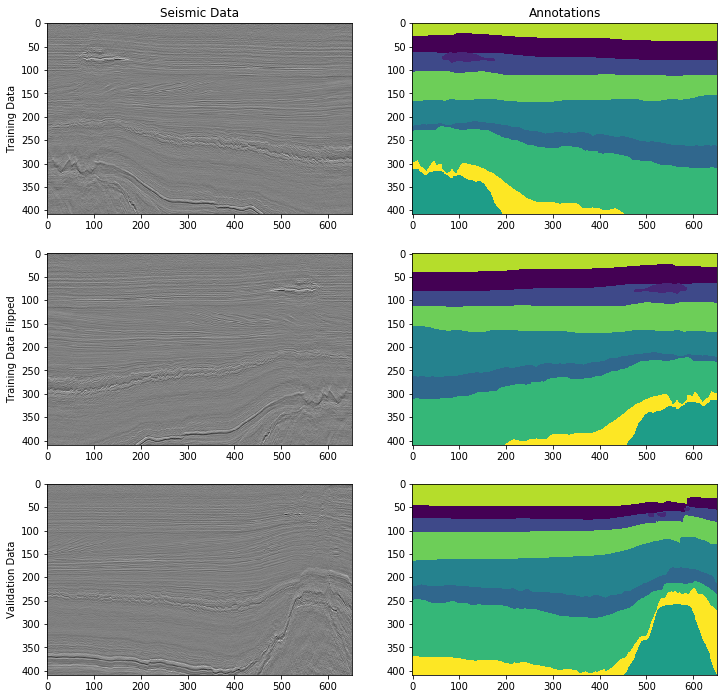

In [111]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(train_image_normed, vmin=-train_std, vmax=train_std, cmap="gray")
ax[0, 1].imshow(train_annotation, vmin=0, vmax=9)

ax[1, 0].imshow(train_image_normed[:, ::-1], vmin=-train_std, vmax=train_std, cmap="gray")
ax[1, 1].imshow(train_annotation[:, ::-1], vmin=0, vmax=9)


ax[2, 0].imshow(validation_image_normed, vmin=-train_std, vmax=train_std, cmap="gray")
ax[2, 1].imshow(validation_annotation, vmin=0, vmax=9)

ax[0, 0].set_ylabel("Training Data")
ax[1, 0].set_ylabel("Training Data Flipped")
ax[2, 0].set_ylabel("Validation Data")
ax[0, 0].set_title("Seismic Data")
ax[0, 1].set_title("Annotations")

In [113]:
window_half_size = 16

def extract_patches(inline, inline_annotation, window_half_size=16, increment=4):
    patches = []
    patches_labels = []
    for i in range(window_half_size, inline.shape[0]-window_half_size-1, increment):
        for j in range(window_half_size, inline.shape[1]-window_half_size-1, increment):
            patches.append(inline[i-window_half_size:i+window_half_size+1, j-window_half_size:j+window_half_size+1])
            patches_labels.append(inline_annotation[i, j])
    return np.expand_dims(np.array(patches), -1), np.expand_dims(np.array(patches_labels), -1)

train_patches = extract_patches(train_image_normed, train_annotation)
train_patches_flipped = extract_patches(train_image_normed[:, ::-1], train_annotation[:, ::-1])
validation_patches = extract_patches(validation_image_normed, validation_annotation)

prediction_patches = extract_patches(validation_image_normed, validation_annotation, increment=1)

print(train_patches[0].shape, train_patches_flipped[0].shape, validation_patches[0].shape)
print(train_patches[1].shape, train_patches_flipped[1].shape, validation_patches[1].shape)

(14570, 33, 33, 1) (14570, 33, 33, 1) (14570, 33, 33, 1)
(14570, 1) (14570, 1) (14570, 1)


In [114]:
batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 33, 33

x_train = np.concatenate([train_patches[0], train_patches_flipped[0]], 0)
y_train = np.concatenate([train_patches[1], train_patches_flipped[1]], 0)

x_val, y_val = validation_patches

x_pred, y_pred = prediction_patches

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    x_pred = x_pred.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_pred = x_pred.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_pred = keras.utils.to_categorical(y_pred, num_classes)

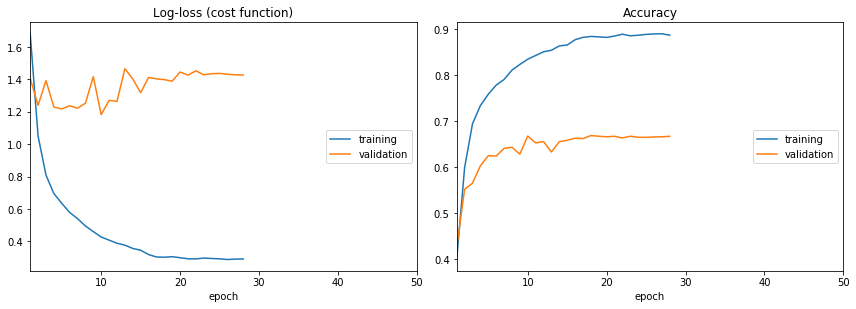


Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00028: early stopping
Validation loss: 1.39767915883238
Validation accuracy: 0.6688400823610158


In [115]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

early_cbk = EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=1)
learning_cbk = ReduceLROnPlateau(monitor='val_acc', mode='max', patience=5, factor=0.1, verbose=1)
checkpointing = ModelCheckpoint('seismic_model.check',
                                save_best_only=True,
                                save_weights_only=True, monitor='val_acc', mode='max')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val), callbacks=[PlotLossesKeras(), early_cbk, learning_cbk, checkpointing])

model.load_weights('seismic_model.check')
score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

In [119]:
y_pred_model = model.predict(x_pred, verbose=1)

232368/232368 [==============================] - 49s 212us/step


In [120]:
height = len(range(window_half_size, validation_annotation.shape[0]-window_half_size-1, 1))
width = len(range(window_half_size, validation_annotation.shape[1]-window_half_size-1, 1))

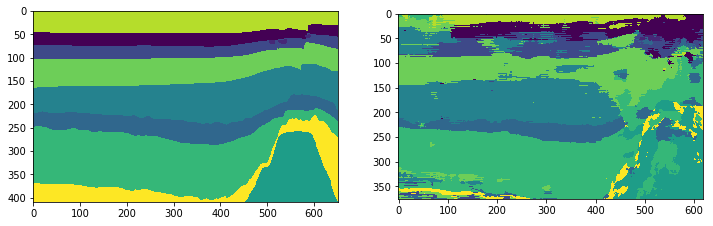

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(validation_annotation)
ax[1].imshow(np.argmax(y_pred_model.reshape(height, width, 10), axis=2))

In [122]:
from sklearn.metrics import confusion_matrix

In [127]:
print(confusion_matrix(y_pred=np.argmax(y_pred_model, 1), y_true=np.argmax(y_pred, 1)))

[[ 6883    33  3515    12  3779     0     0  1105    30     0]
 [   73   228    25    10     0     0     0     0     0     0]
 [ 1144   160  8847   275  2790     0     0  2265     0     0]
 [   16     0     8 12443  3338  1201  4890    13     0   621]
 [   28     0     8   700 29930     0  6503  7031    26     0]
 [    0     0     0   586     0 11474  3492     0     1    90]
 [    0     0   242   487  1126  2245 50525  1710     9  1485]
 [  788    53  1751   712  4097     0   588 23802   129     0]
 [ 6219     0    13     0   101     0   791  2417  9311     0]
 [    0     0   810  1621    56  3906   110  1127     0  2564]]
